In [73]:
import pandas as pd
from clinical_scores import hiat_score, thrive_score, span100_score
from sklearn import metrics
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
data_path = '/Users/jk1/OneDrive - unige.ch/stroke_research/geneva_stroke_dataset/clinical_data/multi_annual_joined_data/scope_joined_variables/with_imaging_curated_completed_joined_anon_outcome_df.xlsx'


In [4]:
data_df = pd.read_excel(data_path)

In [58]:
data_df['3M mRS 0-1'] = data_df['3M mRS'] < 2
data_df['3M mRS 0-2'] = data_df['3M mRS'] < 3

In [6]:
data_df['HIAT_prob'] =  data_df.apply(
    lambda subject: hiat_score(
        subject['Age (calc.)'],
        subject['NIH on admission'],
        subject['1st glucose']),
    axis=1)

# defined as mRS < 4 at discharge
data_df['HIAT good outcome pred'] = data_df['HIAT_prob'] > 0.5

In [7]:
data_df['span100_prob'] =  data_df.apply(
    lambda subject: span100_score(
        subject['Age (calc.)'],
        subject['NIH on admission']),
    axis=1)
data_df['span100 good outcome pred'] = data_df['span100_prob'] > 0.5

In [8]:
data_df['THRIVE_prob'] = data_df.apply(
    lambda subject: thrive_score(
        subject['Age (calc.)'],
        subject['NIH on admission'],
        subject['MedHist Hypertension'],
        subject['MedHist Diabetes'],
        subject['MedHist Atrial Fibr.']
    ),
    axis=1)

data_df['THRIVE good outcome pred'] = data_df['THRIVE_prob'] > 0.5

In [50]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
auc = tf.keras.metrics.AUC()
accuracy = tf.keras.metrics.Accuracy()

def plot_roc_curve(fpr, tpr, name:str):
    sns.lineplot(x=fpr, y=tpr, color='orange', label=name)
    sns.lineplot(x=[0, 1], y=[0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve of {name}')
    plt.legend()
    plt.show()

In [65]:
result_columns = ['ground truth', 'method', 'auc', 'accuracy', 'f1', 'precision', 'recall',
                  'fpr', 'tpr', 'roc_thresholds']

In [66]:
def evaluate_method(method_name:str, data_df, ground_truth:str='3M mRS 0-1'):
    method_auc = auc(data_df[f'{method_name} good outcome pred'], data_df[ground_truth]).numpy()
    method_acc = accuracy(data_df[f'{method_name} good outcome pred'], data_df[ground_truth]).numpy()
    method_f1 = metrics.f1_score(data_df[f'{method_name} good outcome pred'],data_df[ground_truth])
    method_precision = precision(data_df[f'{method_name} good outcome pred'], data_df[ground_truth]).numpy()
    method_recall = recall(data_df[f'{method_name} good outcome pred'], data_df[ground_truth]).numpy()
    method_fpr, method_tpr, method_thresholds = metrics.roc_curve(
                            data_df[ground_truth],
                            data_df[f'{method_name}_prob']
                                                                  )

    method_df = pd.DataFrame(
        [[ground_truth, method_name, method_auc, method_acc, method_f1, method_precision, method_recall,
         method_fpr, method_tpr, method_thresholds]],
        columns=result_columns)

    plot_roc_curve(method_fpr, method_tpr, method_name)

    return method_df

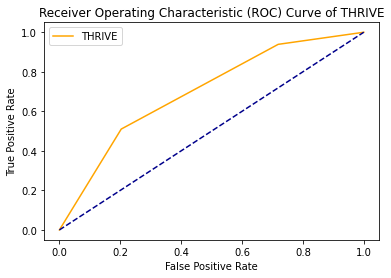

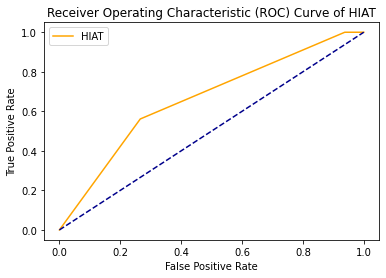

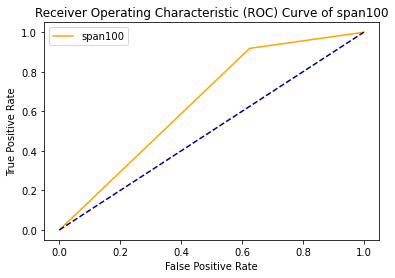

,ground truth,method,auc,accuracy,f1,precision,recall,fpr,tpr,roc_thresholds
0,3M mRS 0-2,THRIVE,0.646313,0.648148,0.621118,0.656452,0.686341,"[0.0, 0.203125, 0.71875, 1.0]","[0.0, 0.5102040816326531, 0.9387755102040817, ...","[1.647, 0.647, 0.435, 0.106]"
0,3M mRS 0-2,HIAT,0.645304,0.646914,0.647059,0.649477,0.690779,"[0.0, 0.265625, 0.796875, 0.9375, 1.0]","[0.0, 0.5612244897959183, 0.9081632653061225, ...","[1.56, 0.56, 0.32999999999999996, 0.0300000000..."
0,3M mRS 0-2,span100,0.647371,0.650463,0.789474,0.667827,0.690922,"[0.0, 0.625, 1.0]","[0.0, 0.9183673469387755, 1.0]","[1.554, 0.554, 0.056]"


In [72]:
thrive_df = evaluate_method('THRIVE', data_df, ground_truth='3M mRS 0-2')
hiat_df = evaluate_method('HIAT', data_df, ground_truth='3M mRS 0-2')
span100_df = evaluate_method('span100', data_df, ground_truth='3M mRS 0-2')

mrs02_result_df = pd.concat([thrive_df, hiat_df, span100_df])
mrs02_result_df

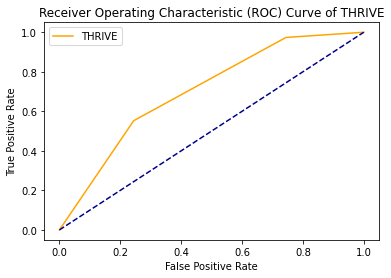

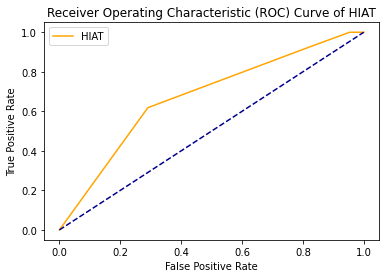

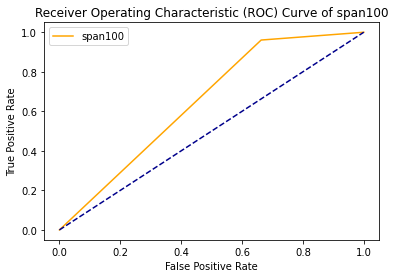

,ground truth,method,auc,accuracy,f1,precision,recall,fpr,tpr,roc_thresholds
0,3M mRS 0-1,THRIVE,0.648691,0.650393,0.604317,0.650505,0.699240,"[0.0, 0.2441860465116279, 0.7441860465116279, ...","[0.0, 0.5526315789473685, 0.9736842105263158, ...","[1.647, 0.647, 0.435, 0.106]"
0,3M mRS 0-1,HIAT,0.650775,0.651749,0.635135,0.648218,0.695871,"[0.0, 0.29069767441860467, 0.813953488372093, ...","[0.0, 0.618421052631579, 0.9210526315789473, 1...","[1.56, 0.56, 0.32999999999999996, 0.0300000000..."
0,3M mRS 0-1,span100,0.647892,0.650047,0.708738,0.669002,0.680321,"[0.0, 0.6627906976744186, 1.0]","[0.0, 0.9605263157894737, 1.0]","[1.554, 0.554, 0.056]"


In [71]:
thrive_df = evaluate_method('THRIVE', data_df, ground_truth='3M mRS 0-1')
hiat_df = evaluate_method('HIAT', data_df, ground_truth='3M mRS 0-1')
span100_df = evaluate_method('span100', data_df, ground_truth='3M mRS 0-1')

mrs01_result_df = pd.concat([thrive_df, hiat_df, span100_df])
mrs01_result_df

In [74]:
output_dir = '/Users/jk1/OneDrive - unige.ch/stroke_research/scope/output/clinical_scores'
mrs02_result_df.to_csv(os.path.join(output_dir, 'mrs02_clinical_scores_results.csv'))
mrs01_result_df.to_csv(os.path.join(output_dir, 'mrs01_clinical_scores_results.csv'))